<a href="https://colab.research.google.com/github/kazirafshanhasin/Formula-1-Analysks/blob/main/F1_Pit_Stop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

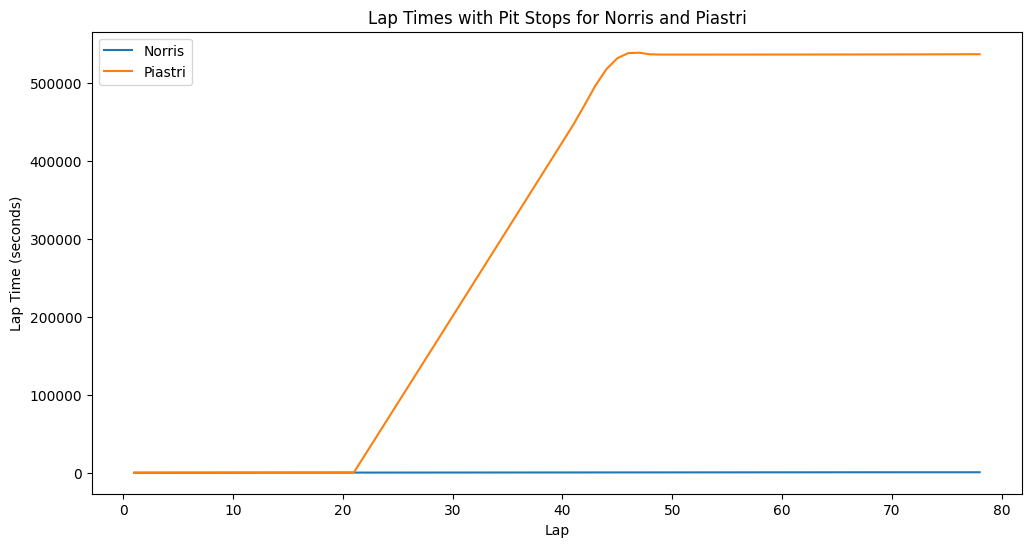


Lap Times and Pit Stops for Norris:
Lap 1: Pit Stop = 3925538.000 seconds
Lap 66: Lap Time = 2.219 seconds
Lap 78: Lap Time = 8.650 seconds

Lap Times and Pit Stops for Piastri:
Lap 21: Pit Stop = 22224.000 seconds
Lap 46: Pit Stop = 22420.000 seconds
Lap 66: Lap Time = 33.760 seconds
Lap 78: Lap Time = 7.152 seconds


In [ ]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
from scipy import stats, integrate

def fetch_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def extract_lap_times(race_results):
    lap_times = []
    for result in race_results['MRData']['RaceTable']['Races'][0]['Results']:
        if 'Time' in result:
            lap_times.append({
                'driverId': result['Driver']['driverId'],
                'lap': int(result['laps']),
                'time': result['Time']['time']
            })
    return pd.DataFrame(lap_times)

def extract_pit_stops(pitstops):
    pit_stop_data = []
    for pitstop in pitstops['MRData']['RaceTable']['Races'][0]['PitStops']:
        pit_stop_data.append({
            'driverId': pitstop['driverId'],
            'lap': int(pitstop['lap']),
            'duration': pitstop['duration']
        })
    return pd.DataFrame(pit_stop_data)

def fetch_and_extract_data(race_number, driver):
    race_results = fetch_data(f'http://ergast.com/api/f1/2024/{race_number}/results.json')
    pitstops = fetch_data(f'http://ergast.com/api/f1/2024/{race_number}/drivers/{driver}/pitstops.json')
    if race_results and pitstops:
        lap_times = extract_lap_times(race_results)
        pit_stops = extract_pit_stops(pitstops)
        return lap_times, pit_stops
    else:
        return None, None

def convert_time_to_seconds(time):
    parts = time.split(':')
    hours = 0
    minutes = 0
    if len(parts) == 3:
        hours, minutes, seconds = parts
        seconds, milliseconds = seconds.split('.')
    elif len(parts) == 2:
        minutes, seconds = parts
        seconds, milliseconds = seconds.split('.')
    else:
        seconds, milliseconds = parts[0].split('.')
    return int(hours) * 3600 + int(minutes) * 60 + int(seconds) + int(milliseconds) / 1000

# Fetch and extract data for each race
race_8_lap_times, race_8_pit_stops = fetch_and_extract_data(8, 'Norris')
race_10_lap_times, race_10_pit_stops = fetch_and_extract_data(10, 'Piastri')

# Combine lap times and pit stops
combined_lap_times = pd.concat([race_8_lap_times, race_10_lap_times], ignore_index=True)
combined_pitstops = pd.concat([race_8_pit_stops, race_10_pit_stops], ignore_index=True)

# Convert lap times to seconds
combined_lap_times['time_seconds'] = combined_lap_times['time'].apply(convert_time_to_seconds)

# Filter data for Norris and Piastri
drivers = ['norris', 'piastri']
filtered_lap_times = combined_lap_times[combined_lap_times['driverId'].isin(drivers)]
filtered_pitstops = combined_pitstops[combined_pitstops['driverId'].isin(drivers)]

# Calculate average lap times for each driver
average_lap_times = filtered_lap_times.groupby('driverId')['time_seconds'].mean().reset_index()
average_lap_times.columns = ['driverId', 'average_lap_time']

# Calculate average pit stop durations for each driver
filtered_pitstops['duration'] = filtered_pitstops['duration'].str.replace(r'\D', '', regex=True).astype(float)
average_pitstops = filtered_pitstops.groupby('driverId')['duration'].mean().reset_index()
average_pitstops.columns = ['driverId', 'average_pitstop_duration']

# Differential equation function for lap times
def lap_time_model(t, y, driver):
    lap_time = np.interp(t, driver_laps[driver], driver_times[driver])
    pit_stop_effect = np.interp(t, driver_pit_laps[driver], driver_pit_durations[driver], left=0, right=0)
    return lap_time + pit_stop_effect

# Prepare data for modeling
driver_laps = {driver: filtered_lap_times[filtered_lap_times['driverId'] == driver]['lap'].values for driver in drivers}
driver_times = {driver: filtered_lap_times[filtered_lap_times['driverId'] == driver]['time_seconds'].values for driver in drivers}
driver_pit_laps = {driver: filtered_pitstops[filtered_pitstops['driverId'] == driver]['lap'].values for driver in drivers}
driver_pit_durations = {driver: filtered_pitstops[filtered_pitstops['driverId'] == driver]['duration'].values for driver in drivers}

# Solve differential equation for each driver
lap_range = np.arange(1, max(filtered_lap_times['lap']) + 1)
norris_sol = integrate.solve_ivp(lap_time_model, [lap_range[0], lap_range[-1]], [0], args=('norris',), t_eval=lap_range)
piastri_sol = integrate.solve_ivp(lap_time_model, [lap_range[0], lap_range[-1]], [0], args=('piastri',), t_eval=lap_range)

# Function to display pit stops and lap times
def display_pit_stops_and_lap_times():
    for driver in drivers:
        print(f"\nLap Times and Pit Stops for {driver.capitalize()}:")
        driver_lap_times = filtered_lap_times[filtered_lap_times['driverId'] == driver]
        driver_pit_stops = filtered_pitstops[filtered_pitstops['driverId'] == driver]
        for lap in range(1, max(driver_lap_times['lap']) + 1):
            lap_time = driver_lap_times[driver_lap_times['lap'] == lap]['time_seconds']
            if not lap_time.empty:
                print(f"Lap {lap}: Lap Time = {lap_time.values[0]:.3f} seconds")
            pit_stop = driver_pit_stops[driver_pit_stops['lap'] == lap]['duration']
            if not pit_stop.empty:
                print(f"Lap {lap}: Pit Stop = {pit_stop.values[0]:.3f} seconds")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(norris_sol.t, norris_sol.y[0], label='Norris')
plt.plot(piastri_sol.t, piastri_sol.y[0], label='Piastri')
plt.xlabel('Lap')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Times with Pit Stops for Norris and Piastri')
plt.legend()
plt.show()

# Function to print all the results and display graphs to compare
def print_results_and_display_graphs():
    print("Average Lap Times:")
    print(average_lap_times)
    print("\nAverage Pit Stop Durations:")
    print(average_pitstops)

display_pit_stops_and_lap_times()

In [ ]:
# Function to print all the results
def print_results():
    print("Average Lap Times:")
    print(average_lap_times)
    print("\nAverage Pit Stop Durations:")
    print(average_pitstops)

# Execute functions to display results and graphs
print_results()

Average Lap Times:
  driverId  average_lap_time
0   norris            5.4345
1  piastri           20.4560

Average Pit Stop Durations:
  driverId  average_pitstop_duration
0   norris                 3925538.0
1  piastri                   22322.0


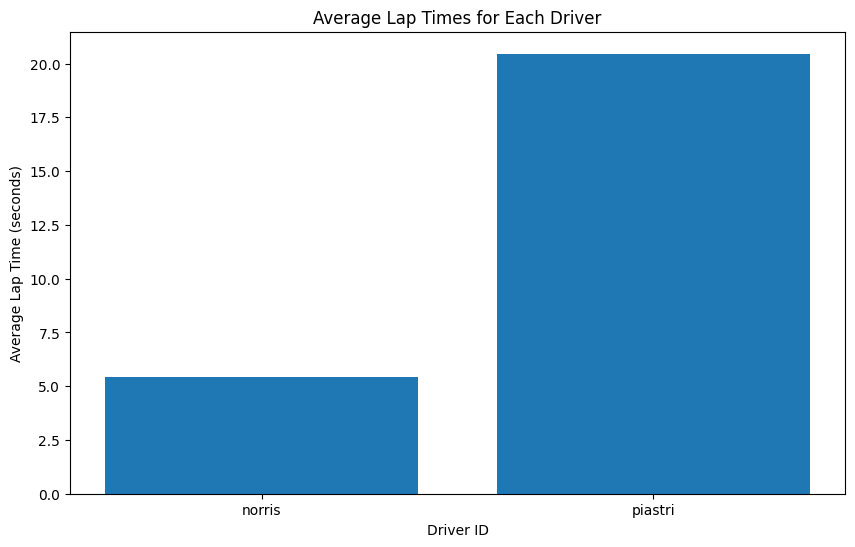

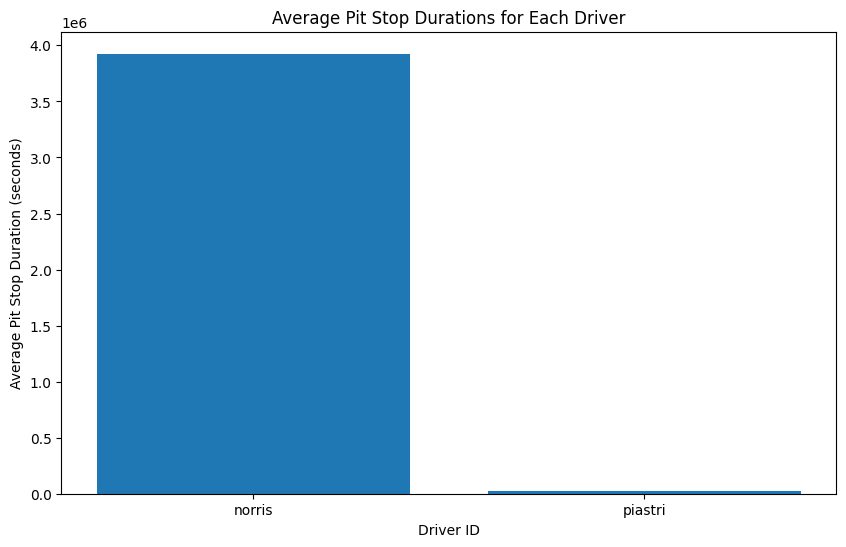

In [ ]:
# Function to display graphs to compare
def display_graphs():
    # Display graph to compare average lap times
    plt.figure(figsize=(10, 6))
    plt.bar(average_lap_times['driverId'], average_lap_times['average_lap_time'])
    plt.xlabel('Driver ID')
    plt.ylabel('Average Lap Time (seconds)')
    plt.title('Average Lap Times for Each Driver')
    plt.show()

    print("\n\n\n")

    # Display graph to compare average pit stop durations
    plt.figure(figsize=(10, 6))
    plt.bar(average_pitstops['driverId'], average_pitstops['average_pitstop_duration'])
    plt.xlabel('Driver ID')
    plt.ylabel('Average Pit Stop Duration (seconds)')
    plt.title('Average Pit Stop Durations for Each Driver')
    plt.show()

# Execute functions to display graphs
display_graphs()